In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/paultimothymooney/blood-cells')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maniyarsuyash
Your Kaggle Key: ··········


100%|██████████| 108M/108M [00:00<00:00, 191MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd blood-cells

/content/blood-cells


In [ ]:
%cd dataset2-master/dataset2-master/images

/content/blood-cells/dataset2-master/dataset2-master/images


In [ ]:
DATA_DIR = '/content/blood-cells/dataset2-master/dataset2-master'


TRAIN_DIR = DATA_DIR + '/images/TRAIN'                           # Contains training images
TEST_DIR = DATA_DIR + '/images/TEST'                             # Contains test images

LABELS_CSV = DATA_DIR + '/labels.csv'                       # Contains real labels for training images

In [ ]:
%cd ..

/content/blood-cells/dataset2-master/dataset2-master


In [ ]:
df = pd.read_csv("labels.csv") 

In [ ]:
df

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
...,...,...,...
406,NaN,406,NaN
407,NaN,407,NEUTROPHIL
408,NaN,408,NEUTROPHIL
409,NaN,409,NEUTROPHIL


In [ ]:
!ls "{TRAIN_DIR}" | head

EOSINOPHIL
LYMPHOCYTE
MONOCYTE
NEUTROPHIL


In [ ]:
!ls "{TRAIN_DIR}/EOSINOPHIL" | head

_0_1169.jpeg
_0_1414.jpeg
_0_207.jpeg
_0_2142.jpeg
_0_2370.jpeg
_0_3072.jpeg
_0_4431.jpeg
_0_4480.jpeg
_0_4574.jpeg
_0_4747.jpeg


In [ ]:
all_eosinophils=os.listdir(TRAIN_DIR + "/EOSINOPHIL")
len(all_eosinophils)

2497

In [ ]:
all_eosinophils=os.listdir(TRAIN_DIR + "/EOSINOPHIL")
len(all_eosinophils)

2497

In [ ]:
PROCESSED_DATA_DIR = '/content/blood-cells'
PROCESSED_TRAIN_DIR = PROCESSED_DATA_DIR + '/train'
PROCESSED_TEST_DIR = PROCESSED_DATA_DIR + '/test'
TRAIN_CSV = PROCESSED_DATA_DIR + '/train_labels.csv'
TEST_CSV = PROCESSED_DATA_DIR + '/test_labels.csv'

In [ ]:
def get_labels(folder_path, filename_to_save=None):
  ''' Gets folder path and returns labels dataframe '''
  labels = np.column_stack(([],[],[]))
  dirnames = os.listdir(folder_path)
  for i, dirname in enumerate(dirnames):
    if os.path.isdir(os.path.join(folder_path, dirname)):
      files_list = os.listdir(os.path.join(folder_path, dirname))      
      labels = np.vstack((labels, np.column_stack((([dirname] * len(files_list)),([i] * len(files_list)), files_list))))
  labels_df = pd.DataFrame(labels, columns = ['text_label', 'num_label', 'img_name'])
  if filename_to_save:
    labels_df.to_csv(filename_to_save)
  return labels_df

In [ ]:
train_labels = get_labels(TRAIN_DIR, TRAIN_CSV)

In [ ]:
test_labels = get_labels(TEST_DIR, TEST_CSV)

In [ ]:
lab_test = pd.DataFrame(test_labels.groupby(['text_label', 'num_label']).count())
lab_test

,,img_name
text_label,num_label,
EOSINOPHIL,2,623
LYMPHOCYTE,0,620
MONOCYTE,3,620
NEUTROPHIL,1,624


In [ ]:
lab = pd.DataFrame(train_labels.groupby(['text_label', 'num_label']).count())
lab

,,img_name
text_label,num_label,
EOSINOPHIL,2,2497
LYMPHOCYTE,0,2483
MONOCYTE,3,2478
NEUTROPHIL,1,2499


In [ ]:
labels_dict = {
    0: 'MONOCYTE',
    1: 'EOSINOPHIL',
    2: 'LYMPHOCYTE',
    3: 'NEUTROPHIL',    
}

In [ ]:
import shutil

def move_files(folder_path, folder):
  if not os.path.exists(folder):
    os.makedirs(folder)
  dirnames = os.listdir(folder_path)
  for i, dirname in enumerate(dirnames):
    if os.path.isdir(os.path.join(folder_path, dirname)):
      files_list = os.listdir(os.path.join(folder_path, dirname))
      for item in files_list:
          shutil.move(os.path.join(folder_path, dirname, item), os.path.join(folder, item))
  print(len(os.listdir(folder)), 'files moved.')

In [ ]:
move_files(TRAIN_DIR, PROCESSED_TRAIN_DIR)


9893 files moved.


In [ ]:
duplicated_img_name = list(train_labels[train_labels.img_name.duplicated()]['img_name'])

In [ ]:
removed_df = train_labels[train_labels.img_name.isin(duplicated_img_name)]

In [ ]:
def clean_data(img_dir, df, df_csv, removed_img_dir, removed_file):
  if not os.path.exists(removed_img_dir):
    os.makedirs(removed_img_dir)
  duplicated_img_list = list(df[df.img_name.duplicated()]['img_name'])
  removed_df = df[df.img_name.isin(duplicated_img_list)]
  removed_df.to_csv(removed_file)
  print(removed_df.shape[0], 'ambigous items moved to', removed_file)
  df.drop(index = df.index[df.img_name.isin(duplicated_img_list)], axis = 0, inplace = True)
  df.to_csv(df_csv)
  print('Now shape of dataframe', df.shape)
  
  files_list = os.listdir(img_dir)
  for item in files_list:
    if item in duplicated_img_list:
      shutil.move(os.path.join(img_dir, item), os.path.join(removed_img_dir, item))
  print(len(os.listdir(removed_img_dir)), 'moved to', removed_img_dir)

In [ ]:
clean_data(PROCESSED_TRAIN_DIR, train_labels, TRAIN_CSV, PROCESSED_DATA_DIR + '/removed_train', PROCESSED_DATA_DIR + '/removed_train.csv')

128 ambigous items moved to /content/blood-cells/removed_train.csv
Now shape of dataframe (9829, 3)
64 moved to /content/blood-cells/removed_train


In [ ]:
assert(len(os.listdir(PROCESSED_TRAIN_DIR)) == train_labels.shape[0])

In [ ]:
move_files(TEST_DIR, PROCESSED_TEST_DIR)

2476 files moved.


In [ ]:
duplicated_test_img_name = test_labels[test_labels.img_name.duplicated()]['img_name']


In [ ]:
clean_data(PROCESSED_TEST_DIR, test_labels, TEST_CSV, PROCESSED_DATA_DIR + '/removed_test', PROCESSED_DATA_DIR + '/removed_test.csv')

22 ambigous items moved to /content/blood-cells/removed_test.csv
Now shape of dataframe (2465, 3)
11 moved to /content/blood-cells/removed_test


In [ ]:
assert(len(os.listdir(PROCESSED_TEST_DIR)) == test_labels.shape[0])

In [ ]:
def encode_label(label):
    target = torch.zeros(4)
    target[int(label)] = 1.
    return target

def decode_target(target, text_labels=False):
    result = []
    i = np.argmax(target.numpy())
    if text_labels:
        result.append(labels_dict[i] + "(" + str(i) + ")")
    else:
        result.append(str(i))
    return ' '.join(result)

In [ ]:
class HumanBloodCellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_name, img_label = row['img_name'], row['num_label']
        img_fname = self.root_dir + "/" + str(img_name)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label) 

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = HumanBloodCellDataset(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
dataset = HumanBloodCellDataset(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
class HumanBloodCellDataset2(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_name, img_label = row['img_name'], row['num_label']
        img_fname = self.root_dir + "/" + str(img_name)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img,int(img_label)

In [ ]:
dataset2 = HumanBloodCellDataset2(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
def show_sample(img, target, invert=False):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: MONOCYTE(0)


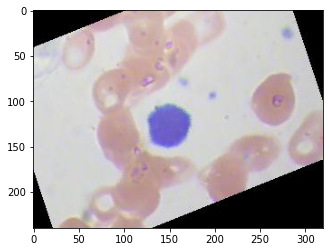

In [ ]:
show_sample(*dataset[0], invert=False)

In [ ]:
torch.manual_seed(10)

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(8847, 982)

In [ ]:
train_ds2, val_ds2 = random_split(dataset2, [train_size, val_size])
len(train_ds2), len(val_ds2)

(8847, 982)

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import random
from torch import nn
from sklearn import svm
train_on_gpu = torch.cuda.is_available()
!pip install torchinfo -q
import torchvision.models as models
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn import svm
import matplotlib.pyplot as plt

In [ ]:
trained_resnet_model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
summary(trained_resnet_model,input_size=(1,3,240,320))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 120, 160]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 120, 160]         128
├─ReLU: 1-3                              [1, 64, 120, 160]         --
├─MaxPool2d: 1-4                         [1, 64, 60, 80]           --
├─Sequential: 1-5                        [1, 256, 60, 80]          --
│    └─Bottleneck: 2-1                   [1, 256, 60, 80]          --
│    │    └─Conv2d: 3-1                  [1, 64, 60, 80]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 60, 80]           128
│    │    └─ReLU: 3-3                    [1, 64, 60, 80]           --
│    │    └─Conv2d: 3-4                  [1, 64, 60, 80]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 60, 80]           128
│    │    └─ReLU: 3-6                    [1, 64, 60, 80]           --
│ 

In [ ]:
kwargs = {
    'batch_size':64,
    'num_workers' : 4, 
    'pin_memory' : True,
}

In [ ]:
train_features=[]
train_labels=[]
test_features=[]
test_labels=[]

In [ ]:
for data in train_dl:
  image, label = data
  image = image.cuda()
  with torch.no_grad():
    x = trained_resnet_model(image)

    train_features.extend(x.cpu().detach().tolist())
    train_labels.extend(label.tolist())

In [ ]:
for data in val_dl :
  image, label = data
  image = image.cuda()
  with torch.no_grad():
    x = trained_resnet_model(image)

    test_features.extend(x.cpu().detach().tolist())
    test_labels.extend(label.tolist())

In [ ]:
train_labels_real=[]
test_labels_real=[]
for i in train_labels:
  train_labels_real.append(i.index(max(i)))


In [ ]:
for i in test_labels:
  test_labels_real.append(i.index(max(i)))

In [ ]:
test_labels

[[0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0,

In [ ]:
len(train_features[0])

1000

In [ ]:
column_name=[]
for i in range(1000):
  column_name.append(i)

In [ ]:
train_df= pd.DataFrame(data = train_features,columns=column_name )
test_df= pd.DataFrame(data = test_features,  columns = column_name)

In [ ]:
X=train_df

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split( X,train_labels_real, test_size=0.1, random_state=42)

In [ ]:
clf_svm = svm.SVC()

In [ ]:
svc=svm.SVC(C=1,kernel='rbf')

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
svc_ovo = OneVsOneClassifier(svc).fit(X,train_labels_real)

In [ ]:
def accuracy(actual,predicted):
  correct=0
  for i in range(len(actual)):
    if predicted[i]==actual[i]:
      correct+=1
  return((correct/len(actual))*100)

In [ ]:
y_pred_svc_OVO = svc_ovo.predict(test_features)

In [ ]:
len(y_pred_svc_OVO)

982

In [ ]:
len(test_labels_real)

982

In [ ]:
y_validate

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(test_labels_real,y_pred_svc_OVO)

0.8370672097759674

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix=confusion_matrix(test_labels_real,y_pred_svc_OVO)

In [ ]:
cf_matrix

array([[216,   8,   9,   7],
       [  9, 207,  20,  20],
       [ 15,  45, 180,  11],
       [  4,   7,   5, 219]])

In [ ]:
import seaborn as sns

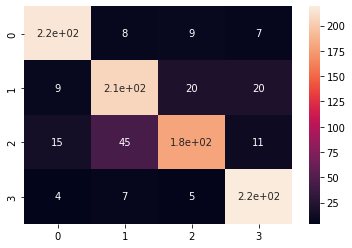

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

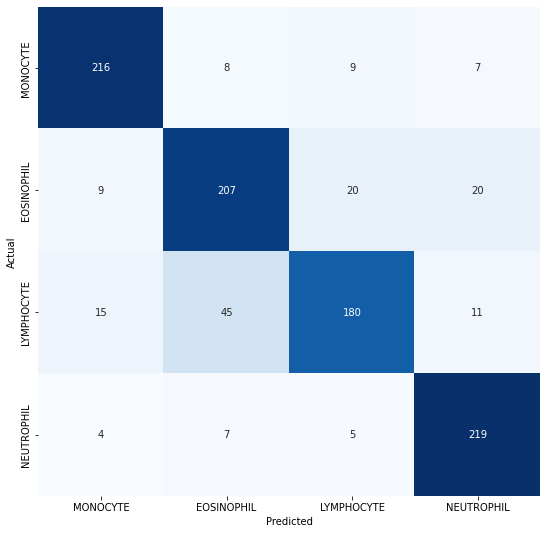

In [ ]:

labels = ['MONOCYTE','EOSINOPHIL','LYMPHOCYTE','NEUTROPHIL']
 

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Fine tuning on a Pre-Trained Model

#Fine Tuning on Resnet Model

In [ ]:
config = {
    'batch_size': 128,
    'num_workers': 4,
    'learning_rate': 0.001,
    'n_epochs': 5,
    'pin_memory': True
}

In [ ]:
import torchvision.models as models
from torchinfo import summary
import torch.optim as optim
resnet_18 = models.resnet18(pretrained=True)
last_layer = resnet_18.fc.in_features
resnet_18.fc = nn.Linear(last_layer,4)
if train_on_gpu:
  resnet_18.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_18.parameters(),lr=config['learning_rate'])

summary(resnet_18,input_size=(1,3,240,320))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 120, 160]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 120, 160]         128
├─ReLU: 1-3                              [1, 64, 120, 160]         --
├─MaxPool2d: 1-4                         [1, 64, 60, 80]           --
├─Sequential: 1-5                        [1, 64, 60, 80]           --
│    └─BasicBlock: 2-1                   [1, 64, 60, 80]           --
│    │    └─Conv2d: 3-1                  [1, 64, 60, 80]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 60, 80]           128
│    │    └─ReLU: 3-3                    [1, 64, 60, 80]           --
│    │    └─Conv2d: 3-4                  [1, 64, 60, 80]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 60, 80]           128
│    │    └─ReLU: 3-6                    [1, 64, 60, 80]           --
│

In [ ]:
def train_model(model ,train_dataloader,test_dataloader, training_name, optimizer,criterion,config=config):


  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  min_loss = float('inf')
  n_epochs = config['n_epochs']
  for epoch in (range(n_epochs)):
    training_loss = 0.0
    train_c = 0
    testing_loss = 0.0
    test_c = 0

    model.train()
    for data in train_dataloader:

      images,labels = data
      images = images.cuda()
      labels = labels.cuda() 
      outputs = model(images)
      loss = criterion(outputs,labels)  
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      train_c += torch.sum(predicted==labels).item()

      training_loss += loss.item()
    print(f'Training accuracy in epoch  {epoch+1}  : {(train_c/len(train_dataloader.dataset))*100:.3f}')
    print(f'Train Loss in epoch {epoch+1}  : {(training_loss/len(train_dataloader)):.3f}')
    print('-'*80)
    print('-'*80)
 
    model.eval()
    with torch.no_grad():
      for data in test_dataloader:
        images,labels = data
        images = images.cuda()
        labels = labels.cuda()
        # Forward Pass 
        outputs = model(images)
        loss = criterion(outputs,labels)

        _, predicted = torch.max(outputs, 1)
        test_c += torch.sum(predicted==labels).item()
        testing_loss += loss.item()

    if min_loss > testing_loss/len(test_dataloader):
      min_loss = testing_loss/len(test_dataloader)
      torch.save(model.state_dict(),f'{training_name}.pth')


    train_acc.append(train_c/len(train_dataloader.dataset))
    train_losses.append(training_loss/len(train_dataloader))
    test_acc.append(test_c / len(test_dataloader.dataset))
    test_losses.append(testing_loss/len(test_dataloader))
    n_epochs = config['n_epochs']
    print(f'Validation accuracy in epoch  {epoch+1}  : {(test_c/len(test_dataloader.dataset))*100:.3f}')
    print(f'Validation Loss in epoch {epoch+1}  : {(testing_loss/len(test_dataloader)):.3f}')
    print('-'*80)
    print('-'*80)

  return train_losses, test_losses, train_acc, test_acc

In [ ]:
def make_plot(train_losses, test_losses, train_acc, test_acc, model_name):
  plt.plot(range(len(train_losses)),train_losses, label = 'Train loss')
  plt.plot(range(len(test_losses)),test_losses, label = 'Test loss')
  plt.title(f'Loss curve for %s' % model_name)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print('\n'*2)
  print('\n'*2)
  
  plt.plot(range(len(train_acc)),train_acc, label = 'Train accuracy')
  plt.plot(range(len(test_acc)),test_acc, label = 'Test accuracy')
  plt.title(f'Accuracy curve for %s' % model_name)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
train_dataloader = DataLoader(
    train_ds2, batch_size=config['batch_size'], shuffle = True, 
    pin_memory = config['pin_memory'], num_workers = config['num_workers']
  )

test_dataloader = DataLoader(
    val_ds2, batch_size=config['batch_size'], shuffle = True, 
    pin_memory = config['pin_memory'], num_workers = config['num_workers']
  )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_ds[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.7529, 0.7961, 0.7961],
          [0.0000, 0.0000, 0.0000,  ..., 0.7373, 0.7412, 0.7529],
          [0.0000, 0.0000, 0.0000,  ..., 0.7843, 0.8275, 0.8118],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.7765, 0.7843, 0.7882],
          [0.0000, 0.0000, 0.0000,  ..., 0.7765, 0.7843, 0.7882],
          [0.0000, 0.0000, 0.0000,  ..., 0.7804, 0.7882, 0.7882]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.7490, 0.7843, 0.7843],
          [0.0000, 0.0000, 0.0000,  ..., 0.7333, 0.7373, 0.7529],
          [0.0000, 0.0000, 0.0000,  ..., 0.7804, 0.8235, 0.8078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6667, 0.6706, 0.6745],
          [0.0000, 0.0000, 0.0000,  ..., 0.6667, 0.6706, 0.6745],
          [0.0000, 0.0000, 0.0000,  ..., 0.6667, 0.6745, 0.6745]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.7294, 0.7569, 0.7569],
          [0.0000, 0.0000, 0.0000,  ..., 0.7137, 0.7176, 0.7216],
          [0.0000, 0.0000, 0.0000,  ...,

In [ ]:
train_losses, test_losses, train_acc, test_acc = train_model(resnet_18,train_dataloader,test_dataloader, 'Resnet 18 finetuned', optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training accuracy in epoch  1  : 92.529
Train Loss in epoch 1  : 0.189
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Validation accuracy in epoch  1  : 89.104
Validation Loss in epoch 1  : 0.311
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  2  : 98.768
Train Loss in epoch 2  : 0.038
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Validation accuracy in epoch  2  : 99.185
Validation Loss in epoch 2  : 0.027
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  3  : 98.678
Train Loss in 

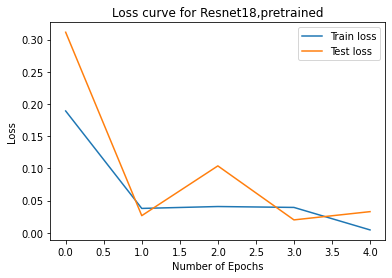

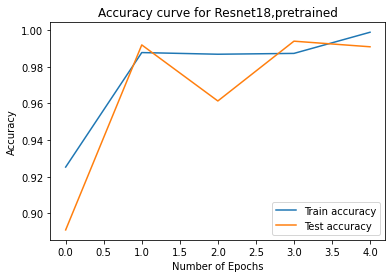

In [ ]:
make_plot(train_losses, test_losses, train_acc, test_acc,"Resnet18,pretrained")

In [ ]:
resnet_18_notfinetuned = models.resnet18(pretrained=False)
last_layer = resnet_18_notfinetuned.fc.in_features
resnet_18_notfinetuned.fc = nn.Linear(last_layer,4)
if train_on_gpu:
  resnet_18_notfinetuned.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_18_notfinetuned.parameters(),lr=config['learning_rate'])

summary(resnet_18_notfinetuned,input_size=(1,3,240,320))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 120, 160]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 120, 160]         128
├─ReLU: 1-3                              [1, 64, 120, 160]         --
├─MaxPool2d: 1-4                         [1, 64, 60, 80]           --
├─Sequential: 1-5                        [1, 64, 60, 80]           --
│    └─BasicBlock: 2-1                   [1, 64, 60, 80]           --
│    │    └─Conv2d: 3-1                  [1, 64, 60, 80]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 60, 80]           128
│    │    └─ReLU: 3-3                    [1, 64, 60, 80]           --
│    │    └─Conv2d: 3-4                  [1, 64, 60, 80]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 60, 80]           128
│    │    └─ReLU: 3-6                    [1, 64, 60, 80]           --
│

In [ ]:
train_losses2, test_losses2, train_acc2, test_acc2 = train_model(resnet_18_notfinetuned,train_dataloader,test_dataloader, 'Resnet 18_notfinetuned', optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training accuracy in epoch  1  : 72.963
Train Loss in epoch 1  : 0.605
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Validation accuracy in epoch  1  : 25.560
Validation Loss in epoch 1  : 39.761
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  2  : 91.161
Train Loss in epoch 2  : 0.227
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Validation accuracy in epoch  2  : 40.631
Validation Loss in epoch 2  : 13.129
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  3  : 93.795
Train Loss i

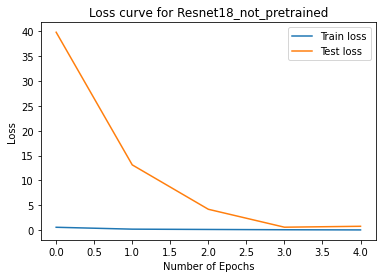

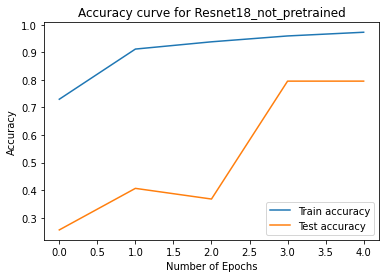

In [ ]:
make_plot(train_losses2, test_losses2, train_acc2, test_acc2,"Resnet18_not_pretrained")

#Makin a MOdel from scratch


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split



config = {
    'batch_size':32,
    'test_size':0.2,
    'num_workers' : 2, 
    'pin_memory' : True,
    'learning_rate' : 0.001,
    'epochs' : 20,
    'test_batch_size': 500
}
kwargs = {
    'batch_size':32,
    'num_workers' : 4, 
    'pin_memory' : True,
}

kwargs_ = {
    'batch_size':500,
    'num_workers' : 4, 
    'pin_memory' : True,
}



In [ ]:
class CNN_1(nn.Module):
  def __init__(self):
      super(CNN_1,self).__init__()
    
      self.conv1 = nn.Conv2d(3,8,3, padding=1)                     #32*32*8
      self.conv2 = nn.Conv2d(8,16,3,padding=1)                     #32*32*16
      self.pool = nn.MaxPool2d(2,2)                                 #16*16*16
      self.conv3 = nn.Conv2d(16,32,3,padding=1)                     #16*16*32
      self.conv4 = nn.Conv2d(32,64,3, padding = 1)
      self.fc1 = nn.Linear(19200,64*8*8)   
      self.fc2 = nn.Linear(64*8*8,64)
      self.fc3 = nn.Linear(64,4)
      #self.softmax = nn.Softmax()
      #self.relu = nn.ReLU(inplace = True)
      #self.sigmoid = nn.Sigmoid()
        
  def forward(self,x):
      x =  self.conv1(x)
      x =  (self.pool(x))
      x =  self.conv2(x)
      x =  (self.pool(x))
      x =  self.conv3(x)
      x =  (self.pool(x))
      x =  self.conv4(x)
      x =  (self.pool(x))
      x =  x.reshape(x.size(0),-1)     #Flatten Layer
      x =  self.fc1(x)
      x =  self.fc2(x)
      x =  self.fc3(x)
      #x =  self.softmax(x)
      return x

In [ ]:
train_losses3, test_losses3, train_acc3, test_acc3 = train_model(CNN_1,train_dataloader,test_dataloader, 'CNN1', optimizer, criterion)

In [ ]:
def train_model(model,train_dataloader,val_dataloader,training_name, config = config):
    epochs = config['epochs']
    train_losses = []
    val_losses = []
    val_acc = []
    train_acc = []
    #net = ConvNet()
    #net.cuda()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(epochs):
        training_loss = 0.0
        val_loss = 0.0
        train_c = 0
        min_loss= 1000 
        val_c = 0
        optimizer = config['optimizer'] 
        criterion = config['criterion']     
        for i, data in enumerate(train_dataloader):
            input_data, labels = data # data is a list of 2, the first element is 4*3*32*32 (4 images) the second element is a list of 4 (classes)
            input_data, labels = input_data.cuda(),labels.cuda()
            optimizer.zero_grad() # every time reset the parameter gradients to zero
            # forward backward optimize
            output = model(input_data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output, 1)
            train_c += torch.sum(predicted==labels).item()
            # print the loss
            training_loss += loss.item()
        # print the loss after every epoch
        train_losses.append(training_loss/40000)
        train_acc.append(train_c/len(train_dataloader.dataset))
        print(f'Training accuracy in epoch  {epoch+1}  : {(train_c/len(train_dataloader.dataset))*100:.3f}')
        print(f'Train Loss in epoch {epoch+1}  : {(training_loss/len(train_dataloader.dataset))*100:.3f}')    
        
        model.eval()
        with torch.no_grad():
          for data in val_dataloader:
            images,classes = data
            images = images.cuda()
            classes = classes.cuda()
            outputs = model(images)
            loss = criterion(outputs,classes)

            _, predicted = torch.max(outputs, 1)
            val_c += torch.sum(predicted==classes).item()
            val_loss += loss.item()

        if min_loss > val_loss/len(val_dataloader):
          min_loss = val_loss/len(val_dataloader)
          torch.save(model.state_dict(),f'{training_name}.pth')

        val_acc.append(val_c / len(val_dataloader.dataset))
        val_losses.append(val_loss/len(val_dataloader))
        print(f'Validation accuracy in epoch  {epoch+1}  : {(val_c/len(val_dataloader.dataset))*100:.3f}')
        print(f'Validation Loss in epoch {epoch+1}  : {(val_loss/len(val_dataloader.dataset))*100:.3f}') 
        print("-"*80)
        print("-"*80)

    print("Training Completed!")
    return train_losses, val_losses, train_acc, val_acc

In [ ]:
model_1 = CNN_1().cuda()
if train_on_gpu:
  model_1.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(),lr=config['learning_rate'])
config['optimizer'] = optimizer
config['criterion']  = criterion

In [ ]:
train_losses3, test_losses3, train_acc3, test_acc3 = train_model(model_1,train_dataloader,test_dataloader, 'CNN1',config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training accuracy in epoch  1  : 26.619
Train Loss in epoch 1  : 1.349
Validation accuracy in epoch  1  : 31.059
Validation Loss in epoch 1  : 1.108
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  2  : 34.305
Train Loss in epoch 2  : 1.053
Validation accuracy in epoch  2  : 29.837
Validation Loss in epoch 2  : 1.180
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  3  : 38.352
Train Loss in epoch 3  : 1.033
Validation accuracy in epoch  3  : 40.631
Validation Loss in epoch 3  : 1.071
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training accuracy in epoch  4  : 41.698
Train Loss in epoch 4  : 1.

In [ ]:
import torch.optim as optim
model_1 = CNN_1().cuda()
if train_on_gpu:
  model_1.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(),lr=config['learning_rate'])
config['optimizer'] = optimizer
config['criterion']  = criterion

summary(model_1,input_size=(1,3,240,320))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_1                                    --                        --
├─Conv2d: 1-1                            [1, 8, 240, 320]          224
├─MaxPool2d: 1-2                         [1, 8, 120, 160]          --
├─Conv2d: 1-3                            [1, 16, 120, 160]         1,168
├─MaxPool2d: 1-4                         [1, 16, 60, 80]           --
├─Conv2d: 1-5                            [1, 32, 60, 80]           4,640
├─MaxPool2d: 1-6                         [1, 32, 30, 40]           --
├─Conv2d: 1-7                            [1, 64, 30, 40]           18,496
├─MaxPool2d: 1-8                         [1, 64, 15, 20]           --
├─Linear: 1-9                            [1, 4096]                 78,647,296
├─Linear: 1-10                           [1, 64]                   262,208
├─Linear: 1-11                           [1, 4]                    260
Total params: 78,934,292
Trainable params: 78,934,292
Non-tr